In [1]:
import pickle
import os
import pandas as pd
from matplotlib import pyplot as plt
os.chdir(os.path.expanduser('~/wcEcoli/'))
# noinspection PyUnresolvedReferences
from wholecell.io.tablereader import TableReader
import io
import numpy as np
from wholecell.io import tsv
from wholecell.utils.filepath import ROOT_PATH
import plotly.graph_objects as go
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import glob
import plotly.express as px

# Load in the monomer count data

In [23]:
# function to match gene symbols to monomer ids
def get_gene_symbols_for_monomer_ids():
	"""
	Extracts the gene symbols for each monomer id in the model.
	Returns: a dictionary mapping monomer ids to gene symbols.
	Code adapted from convert_to_flat.py.
	"""
	RNAS_FILE = os.path.join(ROOT_PATH, 'reconstruction', 'ecoli',
								 'flat', 'rnas.tsv')
	with (io.open(RNAS_FILE, 'rb') as f):
		reader = tsv.reader(f, delimiter='\t')
		headers = next(reader)
		while headers[0].startswith('#'):
			headers = next(reader)

		# extract relevant information
		gene_symbol_index = headers.index('common_name')
		protein_id_index = headers.index('monomer_ids')
		monomer_ids_to_gene_symbols = {}
		for line in reader:
			gene_symbol = line[gene_symbol_index]
			protein_id = list(
				line[protein_id_index][2:-2].split('", "'))[0]
			monomer_ids_to_gene_symbols[protein_id] = gene_symbol

	return monomer_ids_to_gene_symbols

def get_common_name(protein_id):
    """
    Get the common name of a protein given its monomer id.
    Args:
        protein_id: the name of the monomer

    Returns:
        common_name: The common name of the protein.

    """
    if '[' in protein_id:
        protein_id = protein_id[:-3]  # subtract the compartment
        
    if protein_id == 'NG-GFP-MONOMER':
        print('NEW GENE PRESENT')
    else:
        common_name = get_gene_symbols_for_monomer_ids()[protein_id]
    return common_name

In [49]:
# define the 2020 and 2025 model to use:
model_2020 = 'CLNE1'
model_2025 = 'CLClim3NE2'

# read in the data for the 600 minutes simulation: 
PC_600 = pd.read_csv('out/CLClim3NE_3_at_600_mins/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/AvgMonomerCounts_startGen_2.csv')
HL_600 = pd.read_csv('out/CLClim3NE_3_at_600_mins/kb_plot_out/protein_half_lives.tsv', sep='\t')

PC_60 = pd.read_csv('out/CLClim3NE_3_at_60_mins/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/AvgMonomerCounts_startGen_2.csv')
HL_60 = pd.read_csv('out/CLClim3NE_3_at_60_mins/kb_plot_out/protein_half_lives.tsv', sep='\t')

PC_6 = pd.read_csv('out/CLClim3NE_3_at_6_mins/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/AvgMonomerCounts_startGen_2.csv')
HL_6 = pd.read_csv('out/CLClim3NE_3_at_6_mins/kb_plot_out/protein_half_lives.tsv', sep='\t')

PC_36 = pd.read_csv('out/CLClim3NE_3_at_36_seconds/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/AvgMonomerCounts_startGen_2.csv')
HL_36 = pd.read_csv('out/CLClim3NE_3_at_36_seconds/kb_plot_out/protein_half_lives.tsv', sep='\t')

PC_2020 = pd.read_csv(f'out/{model_2020}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/AvgMonomerCounts_startGen_2.csv')
HL_2020 = pd.read_csv(f'out/{model_2020}/kb_plot_out/protein_half_lives.tsv', sep='\t')

PC_2025 = pd.read_csv(f'out/{model_2025}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/AvgMonomerCounts_startGen_2.csv')
HL_2025 = pd.read_csv(f'out/{model_2025}/kb_plot_out/protein_half_lives.tsv', sep='\t')

# todo: make the common name fetching into a dictionary to avoid the time cost of fetching the common name for each monomer id
# add a row to the PC data frame that is average total monomer counts minus the average free monomer counts:
def create_df(PC_df, HL_df):
	# calcuate the estimated complex counts by subtracting the free monomer counts from the total monomer counts:
	PC_df['Estimated Complex Counts'] = PC_df['Average Total Monomer Counts'] - PC_df['Average Free Monomer Counts']
	PC_df['monomer_id'] = PC_df['Monomer ID'].str[:-3] # do this to avoid series issues
	PC_df_modified = PC_df[['monomer_id', 'Average Total Monomer Counts', 'Average Free Monomer Counts', 'Estimated Complex Counts']]
	
	# create a new data frame combining the PC dataframe and HL dataframe: 
	HL_df_modified = HL_df.rename(columns={ "half_life_(min)": "Half Life", "degradation_rate_source": "HL Source"})
	HL_df_modified_copy = HL_df_modified[['monomer_id','Half Life', 'HL Source']]
	
	# merge the two dataframes on the monomer id:
	df = pd.merge(PC_df_modified, HL_df_modified_copy, on='monomer_id', how='inner')
	df = df.rename(columns={'monomer_id': 'Monomer ID'})
	
	# add a column for the common name of the monomers:
	df['Common Name'] = None
	for index, row in df.iterrows():
		common_name = get_common_name(row['Monomer ID'])
		df.at[index, 'Common Name'] = common_name
	
	return df

df_600 = create_df(PC_600, HL_600)
df_60 = create_df(PC_60, HL_60)
df_6 = create_df(PC_6, HL_6)
df_36 = create_df(PC_36, HL_36)
df_2020 = create_df(PC_2020, HL_2020)
df_2025 = create_df(PC_2025, HL_2025)

# create the plots

First identify the data for the three protiens of interest

In [58]:
protins_of_interest = ['G7122-MONOMER', 'EG12454-MONOMER', 'EG12794-MONOMER']

# function to extract the information about the three proteins
def extract_proteins_of_interest(df, proteins_of_interest):
	"""
	Extracts the information about the three proteins of interest from the dataframe.
	Args:
		df: the dataframe to extract the information from
		proteins_of_interest: the list of proteins of interest

	Returns:
		df: the dataframe with only the proteins of interest included
	"""
	df = df[df['Monomer ID'].isin(proteins_of_interest)]
	
	return df

df_600_3 = extract_proteins_of_interest(df_600, protins_of_interest)
df_60_3 = extract_proteins_of_interest(df_60, protins_of_interest)
df_6_3 = extract_proteins_of_interest(df_6, protins_of_interest)
df_36_3 = extract_proteins_of_interest(df_36, protins_of_interest)


# make a dictionary of the Monomer ID to common name
monomer_id_to_common_name = {}
for index, row in df_600_3.iterrows():
	monomer_id = row['Monomer ID']
	common_name = row['Common Name']
	monomer_id_to_common_name[monomer_id] = common_name

df_600_3

,Monomer ID,Average Total Monomer Counts,Average Free Monomer Counts,Estimated Complex Counts,Half Life,HL Source,Common Name
1583,EG12454-MONOMER,609.686169,609.686169,0.0,600.0,600_mins,ybaK
1614,EG12794-MONOMER,5554.124961,5554.124961,0.0,600.0,600_mins,yhbY
2522,G7122-MONOMER,35.351493,35.351493,0.0,600.0,600_mins,yegR


Matplotlib version 

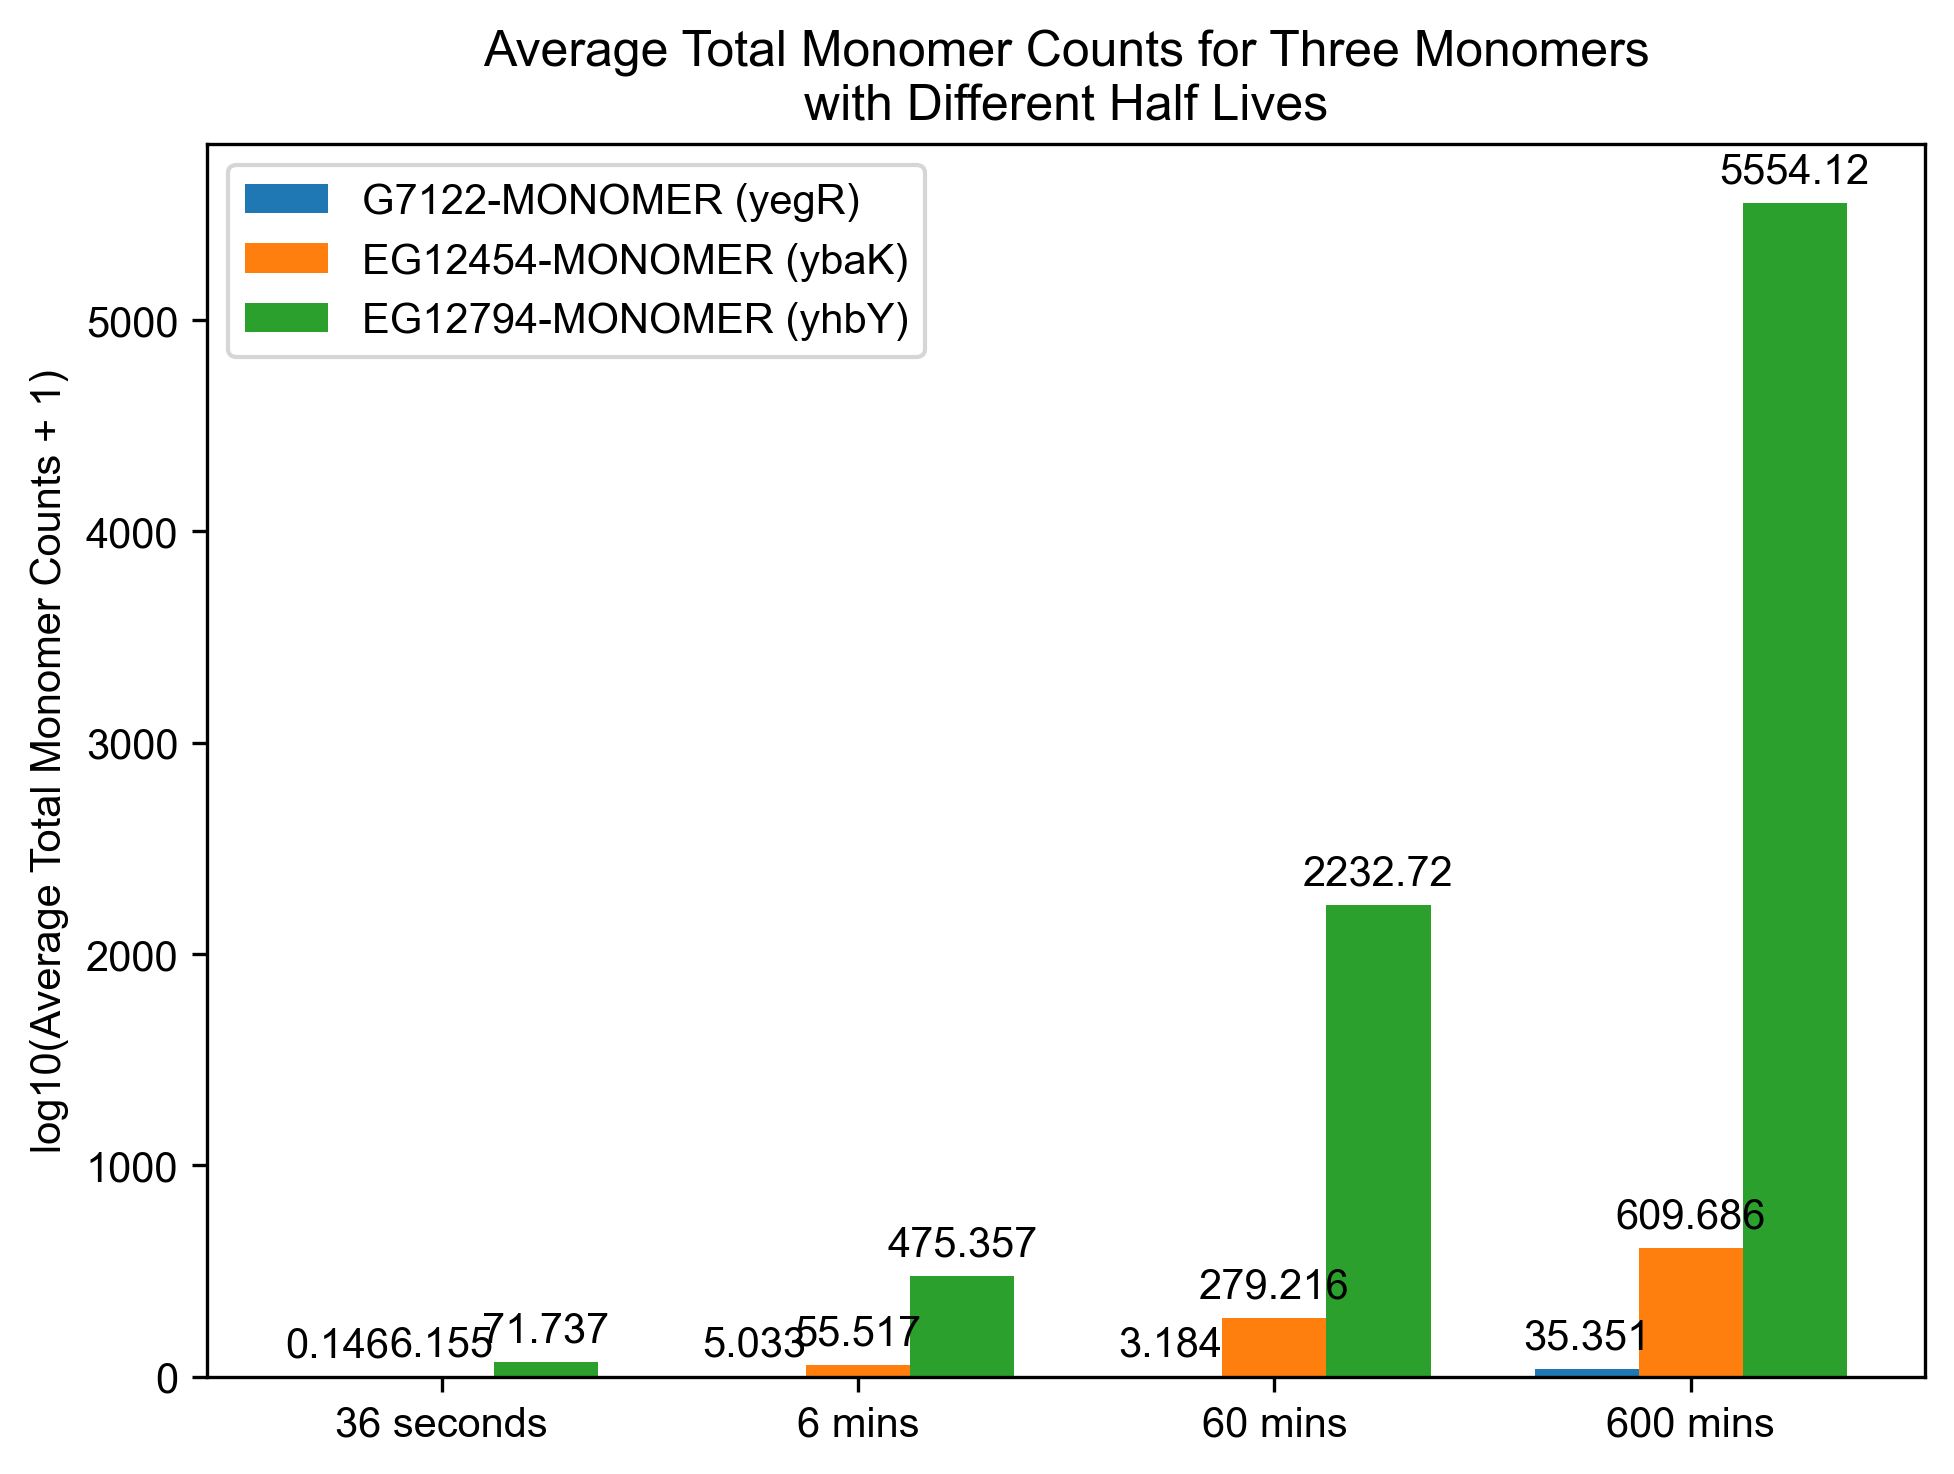

In [59]:
# plot created based on: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/protein_counts_for_different_half_lives/counts_for_3_monomers_at_different_HLs.png"

# create funciton to find the data for each protein: 
def find_data_for_protein(dfs, protein_id):
	"""
	Finds the data for a given protein in the dataframe.
	Args:
		df: the dataframe to search
		protein_id: the id of the protein to find
		
	"""
	# find the data for the protein in each dataframe
	y_data = []
	for df in dfs:
		# append the log10 of the average total monomer counts to the y_data list
		#y_data.append(np.log10(df[df['Monomer ID'] == protein_id]['Average Total Monomer Counts'].values[0] + 1))
		y_data.append(df[df['Monomer ID'] == protein_id]['Average Total Monomer Counts'].values[0])
		
	return y_data

dfs = [df_36_3 , df_6_3, df_60_3, df_600_3]
protins_of_interest = ['G7122-MONOMER', 'EG12454-MONOMER', 'EG12794-MONOMER']

# obtain the value for each protein: 
small_monomer_y_data = find_data_for_protein(dfs, 'G7122-MONOMER')
medium_monomer_y_data = find_data_for_protein(dfs, 'EG12454-MONOMER')
large_monomer_y_data = find_data_for_protein(dfs, 'EG12794-MONOMER')

# for the x axis labels: 
x_data = ['36 seconds', '6 mins', '60 mins', '600 mins']

# create a data frame for the data
data = {f'G7122-MONOMER ({monomer_id_to_common_name["G7122-MONOMER"]})': small_monomer_y_data, f'EG12454-MONOMER ({monomer_id_to_common_name["EG12454-MONOMER"]})': medium_monomer_y_data, f'EG12794-MONOMER ({monomer_id_to_common_name["EG12794-MONOMER"]})': large_monomer_y_data}

x = np.arange(len(x_data))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', dpi=300)

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement, 3), width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('log10(Average Total Monomer Counts + 1)')
ax.set_title('Average Total Monomer Counts for Three Monomers\nwith Different Half Lives')
ax.set_xticks(x + width, x_data)

ax.legend(loc='upper left', ncols=1)
#plt.show()


# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.savefig(out_pth, dpi=300, bbox_inches='tight')


Investigate the actual models

In [54]:
df_2020_3 = extract_proteins_of_interest(df_2020, protins_of_interest)
df_2025_3 = extract_proteins_of_interest(df_2025, protins_of_interest)
df_2020_3

,Monomer ID,Average Total Monomer Counts,Average Free Monomer Counts,Estimated Complex Counts,Half Life,HL Source,Common Name
1583,EG12454-MONOMER,543.769701,543.769701,0.0,600.0,N_end_rule,ybaK
1614,EG12794-MONOMER,4623.596849,4623.596849,0.0,600.0,N_end_rule,yhbY
2522,G7122-MONOMER,5.132922,5.132922,0.0,600.0,N_end_rule,yegR


In [53]:
df_2025_3

,Monomer ID,Average Total Monomer Counts,Average Free Monomer Counts,Estimated Complex Counts,Half Life,HL Source,Common Name
1583,EG12454-MONOMER,663.010270,663.010270,0.0,618.817951,Gupta_et_al_MS_2024,ybaK
1614,EG12794-MONOMER,5307.630366,5307.630366,0.0,617.177306,Gupta_et_al_MS_2024,yhbY
2522,G7122-MONOMER,1.714922,1.714922,0.0,682.571621,Gupta_et_al_MS_2024,yegR


In [56]:



model_dfs = [df_2020_3, df_2025_3]
# obtain the value for each protein: 
small_monomer_y_data = find_data_for_protein(model_dfs, 'G7122-MONOMER')
medium_monomer_y_data = find_data_for_protein(model_dfs, 'EG12454-MONOMER')
large_monomer_y_data = find_data_for_protein(model_dfs, 'EG12794-MONOMER')
small_monomer_y_data

[0.7876674302209864, 0.4337573703861266]